## Plan
1. Obtain data from Kaggle and lyrics from Genius
2. Create Database and Class for songs
    - Database will store data which should be retrieved with Class when called.
3. Train Model on genre using audio features and lyrics
4. Load songs and genre into database
5. Create user interactions through discord 
    - Allow songs within database to get genre from there
    - Allow new songs to be run through model
    - Save new songs to databse

In [1]:
# Import used libraries'
import joblib
import shap
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, 
                              ExtraTreesClassifier, AdaBoostClassifier, StackingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import pandas as pd
from project_functions import *
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from collections import Counter
import sqlite3
import warnings
warnings.filterwarnings('ignore')

/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [2]:
# Load in datasets from csv and combine them and drop duplicates

spotify_2000 = pd.read_csv('data/Spotify-2000.csv', index_col=0)
spotify_tracks = pd.read_csv('data/Spotify-Tracks.csv', index_col=0)
spotify_2000 = spotify_2000[~spotify_2000['Title'].isin(spotify_tracks['Title'])]
spotify_2000 = spotify_2000.drop(columns=['Year','Beats Per Minute (BPM)'])
spotify_tracks = spotify_tracks[spotify_2000.columns]
data = pd.concat([spotify_tracks, spotify_2000], ignore_index=True)
data = data.drop_duplicates(subset=['Title','Artist'], keep='first')


In [3]:
# Filter niche genres into more general ones for training
data = filter_genres(data)

### Filtering out songs to only english songs. This step done in `project_functions.py` since it takes a while

In [7]:
# Load English Song data created from `project_functions.py`
data = pd.read_csv('data/English-Songs.csv', index_col=0) 
data['Genre'].value_counts().to_csv('data/Genre-Counts.csv')
data['Top Genre'].value_counts().to_csv('data/Original-Genres.csv')

In [8]:
# Connect to database and store data
con = sqlite3.connect('data/spotify.db')
cursor = con.cursor()
cursor.execute('DROP TABLE IF EXISTS songs')
data.to_sql('songs', con, index=False)
con.commit()

In [9]:
# Instantiate a Song object for each row in the dataset
songs = []  
for i, row in data.iterrows():
    song = Song(
        name=row['Title'],
        artist=row['Artist'],
        energy=row['Energy'],
        danceability=row['Danceability'],
        loudness=row['Loudness (dB)'],
        liveness=row['Liveness'],
        valence=row['Valence'],
        acousticness=row['Acousticness'],
        speechiness=row['Speechiness'],
        popularity=row['Popularity']
    )
    songs.append(song)

In [10]:
# Split the data into training and testing sets evenly distributing genres in each set

X = data.drop(columns=['Artist','Top Genre','Genre', 'Title', 'Length (Duration)',])  
y = data['Genre']  

# Filter out rare genres
genre_counts = y.value_counts()
rare_genres = genre_counts[genre_counts <= 1].index
y = y.apply(lambda genre: 'Other' if genre in rare_genres else genre)

# Take out the commas in the strings and convert them to floats
for col in X.columns:
    if X[col].dtype == 'object':  # If the column contains strings
        X[col] = X[col].str.replace(',', '').astype(float)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


print("Original distribution:", Counter(y))
print("Training distribution:", Counter(y_train))
print("Testing distribution:", Counter(y_test))

Original distribution: Counter({3: 3549, 9: 2261, 8: 1943, 2: 1645, 7: 1589, 0: 1511, 1: 1129, 5: 554, 4: 209, 6: 176})
Training distribution: Counter({3: 2839, 9: 1809, 8: 1554, 2: 1316, 7: 1271, 0: 1209, 1: 903, 5: 443, 4: 167, 6: 141})
Testing distribution: Counter({3: 710, 9: 452, 8: 389, 2: 329, 7: 318, 0: 302, 1: 226, 5: 111, 4: 42, 6: 35})


In [8]:
# Identify the best model for the dataset


# Define models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Neural Network': MLPClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'),
    'CatBoost': CatBoostClassifier(random_state=42, verbose=0),
    'LightGBM': LGBMClassifier(random_state=42),
    'Extra Trees': ExtraTreesClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Stacking': StackingClassifier(
        estimators=[
            ('cat', CatBoostClassifier(random_state=42, verbose=0)),
            ('lbg', LGBMClassifier(random_state=42)),
            ('xgb', XGBClassifier(random_state=42))
        ],
        final_estimator=LogisticRegression()
    )
}

# Store results
results = []

# Train and evaluate models with cross-validation
for model_name, model in models.items():
    # Perform 5-fold cross-validation on scaled training data
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_weighted')
    mean_f1 = cv_scores.mean()
    
    # Train and predict on test data for detailed classification report
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    test_f1 = report['weighted avg']['f1-score']
    
    # Store results
    results.append({
        'Model': model_name,
        'Cross-Validated F1 (Train)': mean_f1,
        'Test F1-Score': test_f1
    })
    print(f"Model: {model_name}")
    print(classification_report(y_test, y_pred, zero_division=0))
    print("\n")

# Convert results to DataFrame for better readability
results_df = pd.DataFrame(results).sort_values(by='Test F1-Score', ascending=False)
print("Model Evaluation Results:")
print(results_df)

# Identify the best model
best_model = results_df.iloc[0]
print(f"\nBest Model: {best_model['Model']} with Test F1-Score: {best_model['Test F1-Score']:.4f}")


Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.47      0.14      0.22       302
           1       0.57      0.60      0.59       226
           2       0.47      0.65      0.55       329
           3       0.36      0.87      0.51       710
           4       0.00      0.00      0.00        42
           5       0.00      0.00      0.00       111
           6       0.00      0.00      0.00        35
           7       0.27      0.11      0.16       318
           8       0.00      0.00      0.00       389
           9       0.41      0.27      0.32       452

    accuracy                           0.40      2914
   macro avg       0.26      0.26      0.23      2914
weighted avg       0.33      0.40      0.32      2914



Model: Decision Tree
              precision    recall  f1-score   support

           0       0.43      0.48      0.45       302
           1       0.65      0.59      0.62       226
           2       0.56     

/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.wa

Model: Neural Network
              precision    recall  f1-score   support

           0       0.53      0.46      0.49       302
           1       0.68      0.71      0.69       226
           2       0.62      0.58      0.60       329
           3       0.58      0.81      0.68       710
           4       0.18      0.10      0.12        42
           5       0.31      0.09      0.14       111
           6       0.00      0.00      0.00        35
           7       0.74      0.69      0.71       318
           8       0.39      0.29      0.33       389
           9       0.47      0.49      0.48       452

    accuracy                           0.56      2914
   macro avg       0.45      0.42      0.43      2914
weighted avg       0.54      0.56      0.54      2914



Model: XGBoost
              precision    recall  f1-score   support

           0       0.56      0.50      0.53       302
           1       0.75      0.69      0.72       226
           2       0.63      0.64      

/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use t

Model: AdaBoost
              precision    recall  f1-score   support

           0       0.33      0.18      0.23       302
           1       0.27      0.88      0.42       226
           2       0.42      0.25      0.31       329
           3       0.51      0.61      0.56       710
           4       0.16      0.52      0.24        42
           5       0.00      0.00      0.00       111
           6       0.00      0.00      0.00        35
           7       0.52      0.77      0.62       318
           8       0.39      0.04      0.08       389
           9       0.38      0.26      0.31       452

    accuracy                           0.40      2914
   macro avg       0.30      0.35      0.28      2914
weighted avg       0.40      0.40      0.36      2914



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1877
[LightGBM] [Info] Number of

In [9]:
results_df.to_csv('data/Model-Results.csv')

In [10]:
# Further tune the best model using GridSearchCV

xgb = XGBClassifier(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 8],
    'learning_rate': [0.01, 0.2,.3],
    'subsample': [0.8],
    'colsample_bytree': [0.8,]
}


# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

# Evaluate on the test set
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 150, 'subsample': 0.8}
Best Accuracy: 0.624785444558874
Test Accuracy: 0.6108442004118051


In [11]:
## CatBoost was almost the king but it took too long to train so I had to go with XGBoost
# # Define the CatBoost classifier
# cat = CatBoostClassifier(random_state=42, verbose=0)

# # Correct parameter grid
# param_grid = {
#     # Round 1 of hyperparameter tuning
#     'iterations': [100, 200],       
#     'depth': [4, 6, 8],            
#     'learning_rate': [0.01, 0.1, 0.2], 
#     'l2_leaf_reg': [3, 5, 7]  
#     # Round 2 of hyperparameter tuning Never Finishes
#     # 'iterations': [200,300],       
#     # 'depth': [8,10,12],            
#     # 'learning_rate': [0.01, 0.1, 0.2], 
#     # 'l2_leaf_reg': [3, 1, 2]          
# }
   

# # Perform GridSearchCV
# grid_search = GridSearchCV(
#     estimator=cat,
#     param_grid=param_grid,
#     cv=5,                 # 5-fold cross-validation
#     scoring='f1_weighted',  # Scoring metric
#     n_jobs=-1
# )

# # Train the model using grid search
# grid_search.fit(X_train, y_train)

# # Print the best parameters and score
# print("Best Parameters:", grid_search.best_params_)
# print("Best F1-Score:", grid_search.best_score_)


In [12]:
# Save the best model and preprocessing objects
joblib.dump(best_model, 'model/genre_model.pkl')
joblib.dump(scaler, 'model/scaler.pkl')
joblib.dump(label_encoder, 'model/label_encoder.pkl')

['model/label_encoder.pkl']

  0%|          | 0/100 [00:00<?, ?it/s]

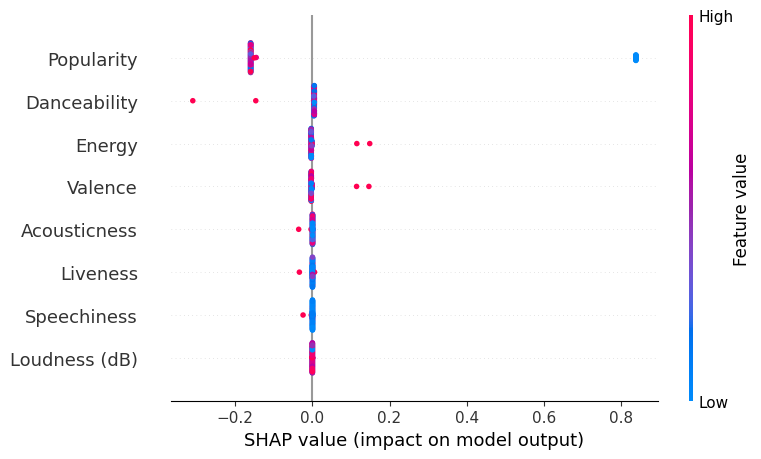

In [19]:
# Create a SHAP summary plot

# Define a custom prediction function
def model_predict(data):
    return model.predict(data)

# Use a small sample of the data to initialize the KernelExplainer
background = X.sample(n=100, random_state=42)

# Initialize the SHAP KernelExplainer with the custom prediction function
explainer = shap.KernelExplainer(model_predict, background)

# Calculate SHAP values for a sample of the data
sample_data = X.sample(n=100, random_state=42)
shap_values = explainer.shap_values(sample_data)

# Plot the SHAP summary plot
%matplotlib inline
shap.summary_plot(shap_values, sample_data)

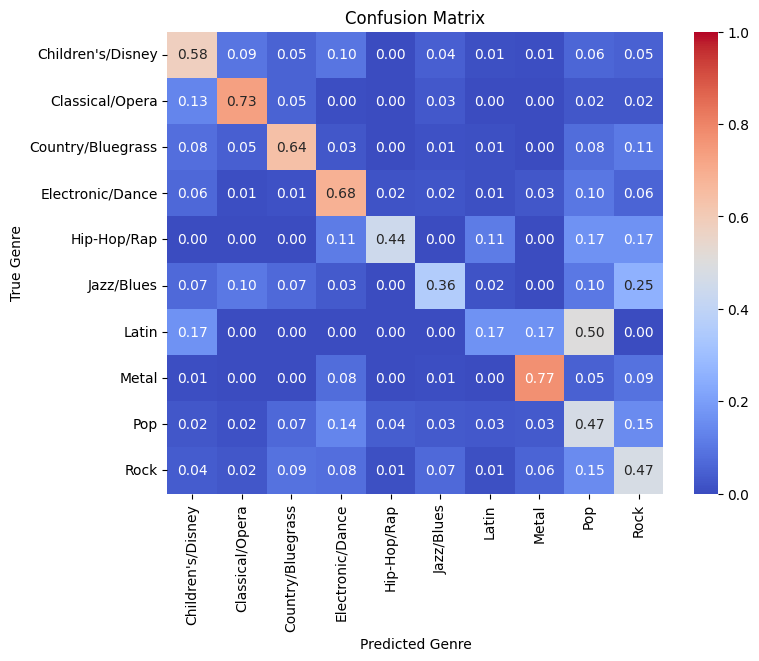

In [25]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict the genres of the test set and store the results
data = pd.read_csv('data/English-Songs.csv', index_col=0) 
model = joblib.load('model/genre_model.pkl')
predicted_genres = []
actual_genres = []
for i,song in enumerate(X_test):
    prediction = model.predict([song])
    prediction = label_encoder.inverse_transform(prediction)
    actual = label_encoder.inverse_transform([y_test[i]])
    predicted_genres.append(prediction[0])
    actual_genres.append(actual[0])

genres = sorted(set(predicted_genres + actual_genres))
cm = confusion_matrix(predicted_genres, actual_genres, labels=genres, normalize='true')

# Convert to a DataFrame for better visualization
cm_df = pd.DataFrame(cm, index=genres, columns=genres)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, vmax=1.0, vmin=0.0)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Genre")
plt.ylabel("True Genre")
plt.show()

### Testing Functions Below

In [16]:
predict_genre('Sweater Weather', 'The Neighbourhood')

Sweater Weather The Neighbourhood


'Rock'

In [17]:
songs[6].lyrics

Database error: no such column: lyrics
Searching for "Shut Up and Dance" by WALK THE MOON...
Done.


'[Chorus]\n"Oh, don\'t you dare look back\nJust keep your eyes on me"\nI said, "You\'re holding back"\nShe said, "Shut up and dance with me"\nThis woman is my destiny\nShe said, ooh-ooh, shut up and dance with me\n\n[Verse 1]\nWe were victims of the night\nThe chemical, physical kryptonite\nHelpless to the bass and the fading light\nOh, we were bound to get together\nBound to get together\n[Pre-Chorus]\nShe took my arm\nI don\'t know how it happened\nWe took the floor and she said\n\n[Chorus]\n"Oh, don\'t you dare look back\nJust keep your eyes on me"\nI said, "You\'re holding back"\nShe said, "Shut up and dance with me"\nThis woman is my destiny\nShe said, ooh-ooh, shut up and dance with me\n\n[Verse 2]\nA backless dress and some beat-up sneaks\nMy discothèque Juliet, teenage dream\nI felt it in my chest as she looked at me\nI knew we were bound to be together\nBound to be together\n[Pre-Chorus]\nShe took my arm\nI don\'t know how it happened\nWe took the floor and she said\n\n[Chorus